In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
import regionmask
import matplotlib.colors as mcolors

In [2]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures/forecast2324_Proba'):
    os.makedirs('figures/forecast2324_Proba')

In [3]:
download = False

## Load Data

In [4]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip_fcast.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip_fcast.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip_fcast.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip_fcast.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip_fcast.nc'

nasageos_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos_path = 'download/nasageos_precip_fcast.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos_url, '-o', nasageos_path])

    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos_path, decode_times=True)
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')
#convert T to pd.datetime
obs_3m['T'] = pd.to_datetime(obs_3m['T'].values, format="%d-%m-%Y")


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')
spi_obs['T'] = pd.to_datetime(spi_obs['T'].values, format="%Y-%m-%d")


landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi_obs.X, spi_obs.Y
)


## Forecast

In [8]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

In [9]:
# First, concatenate all members from all NMME models
print("Concatenating all NMME members...")
all_nmme_data = []
all_member_names = []

for (nmme_name, nmme) in nmme_dict.items():
    print(f"Adding members from {nmme_name}")
    # Add model name to member names for identification
    members = nmme['M'].values
    for member in members:
        member_id = f"{nmme_name}_{member}"
        all_member_names.append(member_id)
        all_nmme_data.append(nmme.sel(M=member))

# Concatenate all members across models
print(f"Total members across all models: {len(all_member_names)}")
combined_nmme = xr.concat(all_nmme_data, dim='M')
combined_nmme = combined_nmme.assign_coords(M=all_member_names)


Concatenating all NMME members...
Adding members from cfsv2
Adding members from gfdlspear
Adding members from cesm1
Adding members from colaccsm4
Adding members from nasageos
Total members across all models: 88


In [123]:

# Now process the combined dataset
print("######################")
print("Processing Combined NMME Ensemble")
print("######################")

P_bar_all = combined_nmme['prec']  # Mean across all members
P_bar = P_bar_all.sel(S=slice('2023-10-01','2024-03-31'))
fcast_starts = P_bar['S'].values

# Initialize storage for all members
x_range = P_bar['X'].values
y_range = P_bar['Y'].values
n_lead = 1
lead = 2.5
total_members = len(all_member_names)

spi_storage = np.full((total_members, len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)

    # Define SPI computation function
def compute_spi_single_grid(i, j, blend_series_season, s, l):
    data_grid = blend_series_season.sel(X=x_range[j], Y=y_range[i])
    t = s + pd.DateOffset(months=int(lead-0.5))
    t_month = t.month


    data_grid_month = data_grid.sel(T=data_grid['T.month'] == t_month).values


    if np.all(np.isnan(data_grid_month)):
        return np.nan

    try:
        a, loc, scale = sp.stats.pearson3.fit(data_grid_month)
        cdf_values = sp.stats.pearson3.cdf(data_grid_month, skew=a, loc=loc, scale=scale)

        q = np.sum(data_grid_month == 0) / len(data_grid_month)
        cdf_values = (cdf_values * (1 - q)) + q
        cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

        spi_time_series = sp.stats.norm.ppf(cdf_values)
        return spi_time_series[-1]
    except Exception as e:
        print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
        return np.nan

# Process each member from the combined ensemble
for m, member_id in enumerate(all_member_names):
    print(f"Processing member {member_id} ({m+1}/{total_members})")
    P_bar_member = combined_nmme.sel(M=member_id)['prec']
    P_bar_mem = P_bar_member.sel(S=slice('2023-01-01','2024-12-31'))


    
    # Process each forecast start for this member
    for s in range(len(fcast_starts)):
        print(f"  Computing SPI for forecast starting {fcast_starts[s]}")
        fcast_start = fcast_starts[s].astype('datetime64[s]').item()
        month = fcast_start.month

        # Compute climatology and anomalies
        P_bar_month = P_bar_mem.sel(S=P_bar_mem['S.month'] == month)
        P_c = P_bar_month.where(P_bar_month['S'] != fcast_starts[s]).mean(dim='S')
        P_a = P_bar_mem - P_c

        
        ty_1 = fcast_start - relativedelta(years=1)
        ty_30 = fcast_start - relativedelta(years=30)

        obs_month = obs.sel(T=obs['T.month'] == month)
        obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
        P_fcst = P_a + obs_climo
        P_fcst_s = P_fcst.sel(S=fcast_start)
        
        # Create forecast time series
        L_values = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])[0:n_lead]
        L_values = [lead]
        T_values = [fcast_start + pd.DateOffset(months=int(L - 0.5)) for L in L_values]
        P_fcst = xr.concat(
            [P_fcst_s.sel(L=L).expand_dims(T=[T]) for L, T in zip(L_values, T_values)],
            dim="T"
        ).drop_vars('L')


        P_obs = obs.sel(T=slice(ty_30, fcast_start - relativedelta(months=1)))
        blend_series = xr.concat([P_obs, P_fcst], dim='T').sortby('T')
        blend_series_season = blend_series + blend_series.shift(T=1) + blend_series.shift(T=2)
        blend_series_season = blend_series_season.dropna('T').sortby('T')


        # Parallelize SPI computation across grid points for each lead time
        def compute_spi_for_time(s, l, blend_series_season):
            return Parallel(n_jobs=-1)(
                delayed(compute_spi_single_grid)(i, j, blend_series_season, s, l)
                for i in range(len(y_range))
                for j in range(len(x_range))
            )

        # Store SPI results for all lead times
        for l in range(n_lead):
            print(f"    Computing SPI for lead time {l + 1}")
            results = compute_spi_for_time(s=fcast_start, l=l, blend_series_season=blend_series_season)
            spi_storage[m, s, l, :, :] = np.array(results).reshape(len(y_range), len(x_range))


# Convert SPI storage to xarray with all members
spi_all_members = xr.DataArray(
    spi_storage,
    dims=['M', 'S', 'L', 'Y', 'X'],
    coords={'M': all_member_names, 'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
    name='spi'
)


######################
Processing Combined NMME Ensemble
######################
Processing member cfsv2_1.0 (1/88)
  Computing SPI for forecast starting 2023-10-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2023-11-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2023-12-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2024-01-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2024-02-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2024-03-01T00:00:00.000000000
    Computing SPI for lead time 1
Processing member cfsv2_2.0 (2/88)
  Computing SPI for forecast starting 2023-10-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast starting 2023-11-01T00:00:00.000000000
    Computing SPI for lead time 1
  Computing SPI for forecast start

In [ ]:
spi_all_members.to_netcdf('data/spi_fcast_all_nmme_members_2324.nc')

In [10]:
spi_all_members = xr.load_dataset('data/spi_fcast_all_nmme_members_2324.nc').spi

In [11]:

# Create probabilistic forecasts by counting categories
print("Creating probabilistic forecasts...")
fcast_starts = spi_all_members['S'].values
y_range = spi_all_members['Y'].values
x_range = spi_all_members['X'].values
n_lead = 1
L_values = [2.5]
prob_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range), 3), np.nan)

for s in range(len(fcast_starts)):
    for l in range(n_lead):
        print(f"Computing probabilities for start {s+1}/{len(fcast_starts)}, lead {l+1}/{n_lead}")
        
        for i in range(len(y_range)):
            for j in range(len(x_range)):
                # Get SPI values across all members for this grid point
                spi_members = spi_all_members[:, s, l, i, j].values
                
                # Skip if all values are NaN
                if not np.all(np.isnan(spi_members)):
                    # Remove NaN values
                    valid_spi = spi_members[~np.isnan(spi_members)]
                    
                    if len(valid_spi) > 0:
                        # Count categories
                        below_normal = np.sum(valid_spi < -0.5)
                        near_normal = np.sum((valid_spi >= -0.5) & (valid_spi <= 0.5))
                        above_normal = np.sum(valid_spi > 0.5)
                        
                        total = len(valid_spi)
                        
                        # Store probabilities [below, near, above]
                        prob_storage[s, l, i, j, 0] = below_normal / total
                        prob_storage[s, l, i, j, 1] = near_normal / total
                        prob_storage[s, l, i, j, 2] = above_normal / total

# Convert to xarray
category_names = ['below_normal', 'near_normal', 'above_normal']
spi_prob_forecast05 = xr.DataArray(
    prob_storage,
    dims=['S', 'L', 'Y', 'X', 'Cat'],
    coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range, 'Cat': category_names},
    name='spi_probability'
)

# Save results
spi_prob_forecast05.to_netcdf('data/spi_prob_fcast_threshold05.nc')

print(f"Completed processing combined NMME ensemble")
print(f"SPI ensemble shape: {spi_all_members.shape}")
print(f"Probabilistic forecast shape: {spi_prob_forecast05.shape}")

Creating probabilistic forecasts...
Computing probabilities for start 1/6, lead 1/1
Computing probabilities for start 2/6, lead 1/1
Computing probabilities for start 3/6, lead 1/1
Computing probabilities for start 4/6, lead 1/1
Computing probabilities for start 5/6, lead 1/1
Computing probabilities for start 6/6, lead 1/1
Completed processing combined NMME ensemble
SPI ensemble shape: (88, 6, 1, 26, 29)
Probabilistic forecast shape: (6, 1, 26, 29, 3)


In [12]:
# Create probabilistic forecasts by counting categories
print("Creating probabilistic forecasts...")
prob_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range), 3), np.nan)

for s in range(len(fcast_starts)):
    for l in range(n_lead):
        print(f"Computing probabilities for start {s+1}/{len(fcast_starts)}, lead {l+1}/{n_lead}")
        
        for i in range(len(y_range)):
            for j in range(len(x_range)):
                # Get SPI values across all members for this grid point
                spi_members = spi_all_members[:, s, l, i, j].values
                
                # Skip if all values are NaN
                if not np.all(np.isnan(spi_members)):
                    # Remove NaN values
                    valid_spi = spi_members[~np.isnan(spi_members)]
                    
                    if len(valid_spi) > 0:
                        # Count categories
                        below_normal = np.sum(valid_spi < -0.5)
                        near_normal = np.sum((valid_spi >= -0.5) & (valid_spi <= 0.5))
                        above_normal = np.sum(valid_spi > 2)
                        
                        total = len(valid_spi)
                        
                        # Store probabilities [below, near, above]
                        prob_storage[s, l, i, j, 0] = below_normal / total
                        prob_storage[s, l, i, j, 1] = near_normal / total
                        prob_storage[s, l, i, j, 2] = above_normal / total

# Convert to xarray
category_names = ['below_normal', 'near_normal', 'above_normal']
spi_prob_forecast1 = xr.DataArray(
    prob_storage,
    dims=['S', 'L', 'Y', 'X', 'Cat'],
    coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range, 'Cat': category_names},
    name='spi_probability'
)

# Save results
spi_all_members.to_netcdf('data/spi_fcast_all_members2324.nc')
spi_prob_forecast1.to_netcdf('data/spi_prob_fcast_threshold1.nc')

print(f"Completed processing combined NMME ensemble")
print(f"SPI ensemble shape: {spi_all_members.shape}")
print(f"Probabilistic forecast shape: {spi_prob_forecast1.shape}")

Creating probabilistic forecasts...
Computing probabilities for start 1/6, lead 1/1
Computing probabilities for start 2/6, lead 1/1
Computing probabilities for start 3/6, lead 1/1
Computing probabilities for start 4/6, lead 1/1
Computing probabilities for start 5/6, lead 1/1
Computing probabilities for start 6/6, lead 1/1
Completed processing combined NMME ensemble
SPI ensemble shape: (88, 6, 1, 26, 29)
Probabilistic forecast shape: (6, 1, 26, 29, 3)


# Inspection

In [11]:
spi_all_members = xr.load_dataset('data/spi_fcast_all_nmme_members_2324.nc').spi
spi_all_members.isel(S=4, L=0).sel(Y = 40, X = 30, method="nearest")

<xarray.DataArray 'spi' (M: 88)> Size: 704B
array([ 2.01856616,  1.23944569,  2.61923336,  1.94917329,  1.60828944,
        1.87530779,  2.18904644,  2.49006357,  2.42775564,  1.23535994,
        1.60341532,  2.80366275,  0.61489746,  0.83544811, -0.42447279,
        2.42420981,  1.89893687,  0.82958201,  0.50363582,  2.23840043,
       -0.08741296, -0.08741296, -0.08741296, -0.08741296, -0.08741296,
       -0.08741296, -0.08741296, -0.08741296,  2.51873845,  1.90541095,
        0.72951094,  2.13529682,  2.24758962,  1.65003637,  1.74732293,
        2.0959196 ,  2.09103725,  0.28093437,  1.37089511,  1.79295164,
        2.15740387,  2.17773567,  0.90467274,  1.79424756,  2.41267505,
        0.9293663 ,  1.86364776,  2.76793604,  1.6925862 ,  2.28178388,
        2.12124679,  2.12704325,  2.59593258,  2.29556066,  2.68499845,
        1.19974129,  2.80586477,  2.44348638, -0.08741296, -0.08741296,
       -0.08741296, -0.08741296, -0.08741296, -0.08741296, -0.08741296,
       -0.08741296, -0.08741296, -0.08741296,  2.43402294,  1.57918322,
        2.14538197,  2.13531611,  1.6525984 ,  2.28944623,  2.13744425,
        1.91132374,  1.60381045,  2.63476775,  1.40513913,  1.96026384,
        2.39312859,  2.1093939 ,  2.45867047,  2.38808619,  1.51574492,
        0.57871217,  0.78475596,  2.37406637])
Coordinates:
  * M        (M) <U14 5kB 'cfsv2_1.0' 'cfsv2_2.0' ... 'nasageos_10.0'
    S        datetime64[ns] 8B 2024-02-01
    L        float64 8B 2.5
    Y        float32 4B 37.0
    X        float32 4B 32.0

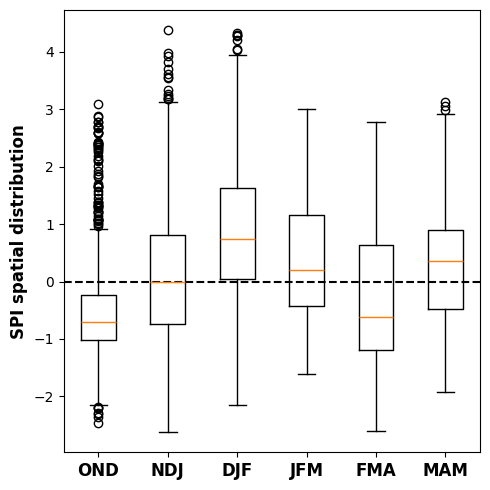

In [27]:
# 1. average over X and Y
spi_members_mean = spi_all_members.mean(dim=['M'])

# 2. convert to DataFrame for plotting
# dims now: (M, S, L) → flatten L if needed or pick one lead
df = spi_members_mean.to_dataframe(name="value").reset_index()

# if you want to select one lead time, e.g. L=2.5
df = df[df["L"] == 2.5]

# 3. pivot for boxplotting
# group by start date (S) and collect values across models (M)
box_data = [grp["value"].values for _, grp in df.groupby("S")]

# 4. plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(box_data, positions=range(len(box_data)))
ax.set_xticks(range(len(box_data)))
plt.axhline(y=0, color='k', linestyle='--')

ax.set_xticklabels(['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM'], fontsize=12, fontdict={'weight': 'bold'})
ax.set_ylabel("SPI spatial distribution", fontsize=12, fontdict={'weight': 'bold'})
plt.tight_layout()
plt.show()

# Skill

In [52]:
spi_prob_forecast05 = xr.open_dataarray('data/spi_prob_fcast_threshold05.nc')
spi_prob_forecast1 = xr.open_dataarray('data/spi_prob_fcast_threshold1.nc')

In [53]:
os.makedirs('figures/forecast2324_Proba', exist_ok=True)

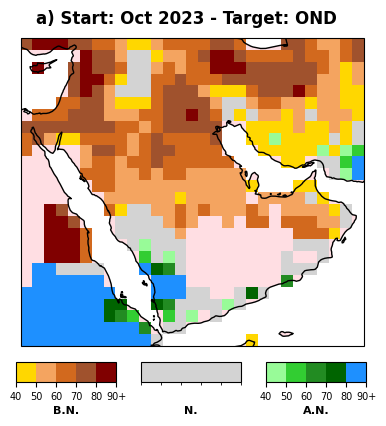

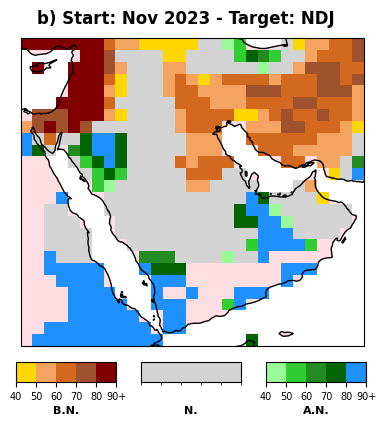

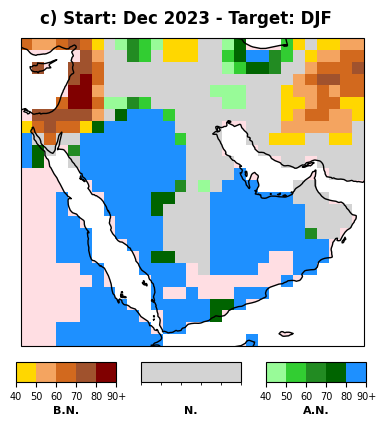

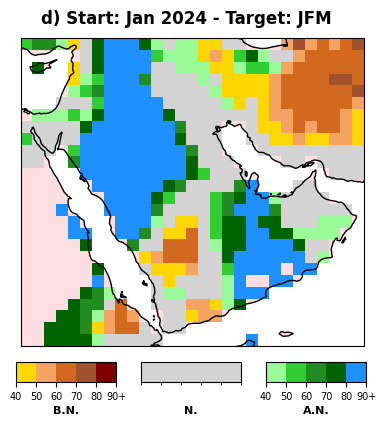

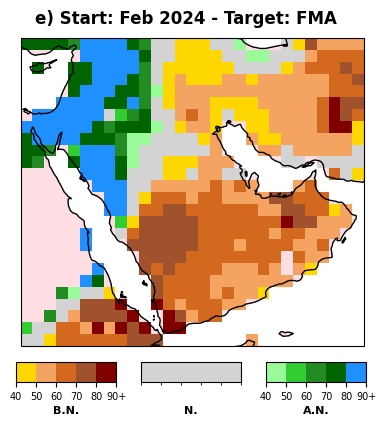

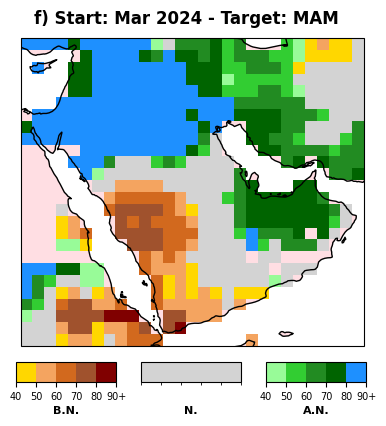

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgba
import pandas as pd
import numpy as np

# --- Labels for seasons ---
seasons_to_label = {"OND":"a)", "NDJ":"b)", "DJF":"c)", "JFM":"d)", "FMA":"e)", "MAM":"f)",
                    "AMJ":"g)", "MJJ":"h)", "JJA":"i)", "JAS":"j)", "ASO":"k)", "SON":"l)"}
seasons = ["NDJ", "DJF", "JFM", "FMA", "MAM", "AMJ", "MJJ", "JJA", "JAS", "ASO", "SON", "OND"]

# --- Define specific color palettes for each category ---
cat_labels = ["Below Normal", "Normal", "Above Normal"]

# --- Discrete probability bins ---
bounds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.90]
n_bins = len(bounds) - 1

# Define specific colors for each category
bn_colors = ["gold", "sandybrown", "chocolate", "sienna", "maroon"]
normal_colors = ["lightgray"]
an_colors = ["palegreen", "limegreen", "forestgreen", "darkgreen", "dodgerblue"]

cat_color_gradients = [bn_colors, normal_colors, an_colors]

for start in spi_prob_forecast05['S'].values:

    prob_fcast_sl = spi_prob_forecast05.sel(S=start, L=2.5)

    target_date = start + pd.DateOffset(months=int(2.5 - 0.5))
    if target_date > spi_obs['T'].values[-1]:
        continue

    mask = np.isnan(spi_obs.sel(T=target_date).where(landmask==0, np.nan))

    # --- Identify dominant category ---
    dominant_cat = prob_fcast_sl.argmax(dim="Cat").where(~mask)

    target_month = pd.to_datetime(target_date).month
    target_season = seasons[target_month - 1]
    label = seasons_to_label[target_season]

    fig, ax = plt.subplots(
        1, 1, figsize=(5, 4),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    ims = []
    for i, colors in enumerate(cat_color_gradients):
        prob_dom_only = prob_fcast_sl.isel(Cat=i).where(dominant_cat == i)

        # Create colormap with specific colors for this category
        cmap_specific = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=n_bins)

        im = ax.pcolormesh(
            prob_fcast_sl['X'], prob_fcast_sl['Y'],
            prob_dom_only,
            cmap=cmap_specific, norm=norm,
            transform=ccrs.PlateCarree()
        )
        ims.append(im)

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

    # --- Discrete colorbars (bottom, same placement as before) ---
    cbar_width = 0.2
    cbar_height = 0.05
    x_start = 0.16
    y_start = 0.02
    x_gap = 0.05
    labels_bottom = ["B.N.", "N.", "A.N."]

    for i, (lab, colors, im) in enumerate(zip(cat_labels, cat_color_gradients, ims)):
        cax = fig.add_axes([x_start + i*(cbar_width + x_gap),
                            y_start, cbar_width, cbar_height])

        # Special handling for Normal category (white) - no ticks or labels
        if i == 1:  # Normal category
            cb = fig.colorbar(
                im, cax=cax, orientation="horizontal",
                boundaries=bounds, spacing="uniform", ticks=[]
            )
        else:
            cb = fig.colorbar(
                im, cax=cax, orientation="horizontal",
                boundaries=bounds, spacing="uniform", ticks=bounds
            )
            cb.set_ticklabels(["40", "50", "60", "70", "80", "90+"])
            cb.ax.tick_params(labelsize=7)

        # add category label under each bar
        x_center = x_start + i*(cbar_width + x_gap) + cbar_width/2
        fig.text(x_center, y_start - 0.06, labels_bottom[i],
                 fontsize=8, fontweight='bold', ha='center', va='top')

    # --- Title ---
    plt.suptitle(
        f"{label} Start: {pd.to_datetime(start).strftime('%b %Y')} - Target: {target_season}",
        fontweight='bold', y=0.95
    )

    #add grid latitude and longitude lines but small fonts
    #gl = ax.gridlines(draw_labels=True)
    #gl.xlabels_top = False
    #l.ylabels_left = False
    #gl.xlabel_style = {'size': 8}
    #gl.ylabel_style = {'size': 8}

    plt.savefig(
        f"figures/forecast2324_Proba/spi_fcast_Target_{target_season}_Start_{pd.to_datetime(start).strftime('%b%Y')}.pdf",
        dpi=300, bbox_inches='tight', pad_inches=0.1
    )
    plt.show()

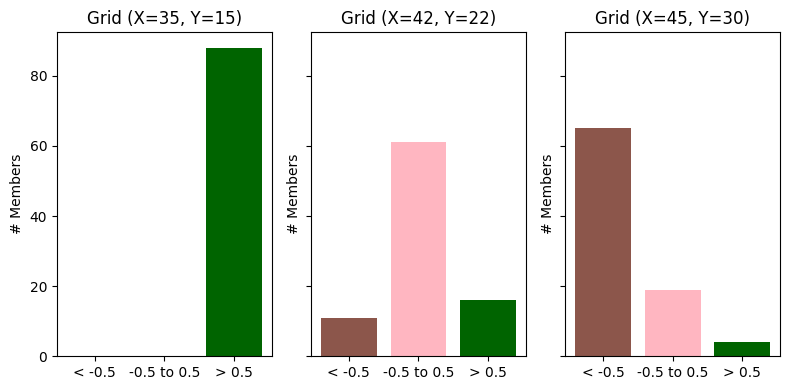

In [47]:
# Example: 3 grid points
points = [(35, 15), (42, 22), (45, 30)]  # (Y, X) pairs

# Categories and colors
categories = ["< -0.5", "-0.5 to 0.5", "> 0.5"]
colors = ["tab:brown", "lightpink", "darkgreen"]

def categorize(values):
    """Count # of members in each category."""
    less = (values < -0.5).sum().item()
    mid = ((values >= -0.5) & (values <= 0.5)).sum().item()
    more = (values >0.5).sum().item()
    return [less, mid, more]

# Collect results
results = []
for (x, y) in points:
    vals = spi_all_members.isel(S=0, L=0).sel(Y=y, X=x, method="nearest")  # shape: (M,)
    res = categorize(vals)
    results.append(res)

results = np.array(results)  # shape: (3, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharey=True)

for i, ax in enumerate(axes):
    ax.bar(categories, results[i], color=colors)
    ax.set_title(f"Grid (X={points[i][0]}, Y={points[i][1]})")
    ax.set_ylabel("# Members")

plt.tight_layout()
plt.show()

In [50]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgba
# import pandas as pd
# import numpy as np

# # --- Labels for seasons ---
# seasons_to_label = {"OND":"a)", "NDJ":"b)", "DJF":"c)", "JFM":"d)", "FMA":"e)", "MAM":"f)",
#                     "AMJ":"g)", "MJJ":"h)", "JJA":"i)", "JAS":"j)", "ASO":"k)", "SON":"l)"}
# seasons = ["NDJ", "DJF", "JFM", "FMA", "MAM", "AMJ", "MJJ", "JJA", "JAS", "ASO", "SON", "OND"]

# # --- Define specific color palettes for each category ---
# cat_labels = ["Below Normal", "Normal", "Above Normal"]

# # --- Discrete probability bins ---
# bounds = [0.4, 0.5, 0.6, 0.7, 0.8]
# n_bins = len(bounds) - 1

# # Define specific colors for each category
# bn_colors = ["gold", "sandybrown", "chocolate", "sienna"]
# normal_colors = ["lightpink"]
# an_colors = ["palegreen", "limegreen", "forestgreen", "blue"]

# cat_color_gradients = [bn_colors, normal_colors, an_colors]

# for start in spi_prob_forecast1['S'].values:

#     prob_fcast_sl = spi_prob_forecast1.sel(S=start, L=2.5)

#     target_date = start + pd.DateOffset(months=int(2.5 - 0.5))
#     if target_date > spi_obs['T'].values[-1]:
#         continue

#     mask = np.isnan(spi_obs.sel(T=target_date).where(landmask==0, np.nan))

#     # --- Identify dominant category ---
#     dominant_cat = prob_fcast_sl.argmax(dim="Cat").where(~mask)

#     target_month = pd.to_datetime(target_date).month
#     target_season = seasons[target_month - 1]
#     label = seasons_to_label[target_season]

#     fig, ax = plt.subplots(
#         1, 1, figsize=(5, 4),
#         subplot_kw={'projection': ccrs.PlateCarree()}
#     )

#     ims = []
#     for i, colors in enumerate(cat_color_gradients):
#         prob_dom_only = prob_fcast_sl.isel(Cat=i).where(dominant_cat == i)

#         # Create colormap with specific colors for this category
#         cmap_specific = ListedColormap(colors)
#         norm = BoundaryNorm(bounds, ncolors=n_bins)

#         im = ax.pcolormesh(
#             prob_fcast_sl['X'], prob_fcast_sl['Y'],
#             prob_dom_only,
#             cmap=cmap_specific, norm=norm,
#             transform=ccrs.PlateCarree()
#         )
#         ims.append(im)

#     ax.coastlines()
#     ax.add_feature(cfeature.LAND, facecolor="gray", alpha=0.4)

#     # --- Discrete colorbars (bottom, same placement as before) ---
#     cbar_width = 0.2
#     cbar_height = 0.05
#     x_start = 0.16
#     y_start = 0.02
#     x_gap = 0.05
#     labels_bottom = ["B.N.", "N.", "A.N."]

#     for i, (lab, colors, im) in enumerate(zip(cat_labels, cat_color_gradients, ims)):
#         cax = fig.add_axes([x_start + i*(cbar_width + x_gap),
#                             y_start, cbar_width, cbar_height])

#         # Special handling for Normal category (white) - no ticks or labels
#         if i == 1:  # Normal category
#             cb = fig.colorbar(
#                 im, cax=cax, orientation="horizontal",
#                 boundaries=bounds, spacing="uniform", ticks=[]
#             )
#         else:
#             cb = fig.colorbar(
#                 im, cax=cax, orientation="horizontal",
#                 boundaries=bounds, spacing="uniform", ticks=bounds
#             )
#             cb.set_ticklabels(["40", "50", "60", "70", "80+"])
#             cb.ax.tick_params(labelsize=7)

#         # add category label under each bar
#         x_center = x_start + i*(cbar_width + x_gap) + cbar_width/2
#         fig.text(x_center, y_start - 0.06, labels_bottom[i],
#                  fontsize=8, fontweight='bold', ha='center', va='top')

#     # --- Title ---
#     plt.suptitle(
#         f"{label} Start: {pd.to_datetime(start).strftime('%b %Y')} - Target: {target_season}",
#         fontweight='bold', y=1.02
#     )

#     plt.savefig(
#         f"figures/forecast2324_Proba/spi_fcast_Target_{target_season}_Start_{pd.to_datetime(start).strftime('%b%Y')}.pdf",
#         dpi=300, bbox_inches='tight', pad_inches=0.3
#     )
#     plt.show()